<a href="https://colab.research.google.com/github/rh2098ta/Practicalapplication3/blob/main/practical3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    make_scorer, accuracy_score, precision_score, recall_score, f1_score
)

sns.set_theme()


In [21]:
df = pd.read_csv("bank-additional-full.csv", sep=";")
df["y"] = (df["y"].str.lower() == "yes").astype(int)

assert "y" in df.columns, "y is missing from df!"
print(df.shape, df["y"].mean())


(41188, 21) 0.11265417111780131


In [22]:
df_small, _ = train_test_split(
    df, train_size=6000, stratify=df["y"], random_state=42
)

assert "y" in df_small.columns, "y is missing from df_small!"
print(df_small["y"].value_counts(normalize=True))


y
0    0.887333
1    0.112667
Name: proportion, dtype: float64


In [23]:
X = df_small.drop(columns=["y"])
y = df_small["y"].values

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                      ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))]), cat_cols),
])


In [24]:
models = {
    "KNN (k=15)": KNeighborsClassifier(n_neighbors=15),
    "Logistic Regression": LogisticRegression(max_iter=300, solver="lbfgs"),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM (RBF, prob=False)": SVC(kernel="rbf", probability=False, random_state=42),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1": make_scorer(f1_score, zero_division=0),
    "roc_auc": "roc_auc",
}

rows = []
for name, model in models.items():
    pipe = Pipeline([("preprocess", preprocess), ("model", model)])
    cv_results = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=1)
    rows.append({
        "Model": name,
        "Accuracy": cv_results["test_accuracy"].mean(),
        "Precision": cv_results["test_precision"].mean(),
        "Recall": cv_results["test_recall"].mean(),
        "F1": cv_results["test_f1"].mean(),
        "ROC_AUC": cv_results["test_roc_auc"].mean(),
    })

results = pd.DataFrame(rows).sort_values("ROC_AUC", ascending=False).reset_index(drop=True)
results


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.915000,0.683776,0.457083,0.546891,0.936819
1,"SVM (RBF, prob=False)",0.912333,0.669960,0.433405,0.524664,0.920550
2,KNN (k=15),0.907500,0.654701,0.375700,0.476589,0.900309
3,Decision Tree,0.890000,0.511571,0.522163,0.516796,0.729433


In [25]:
assert "y" in df_small.columns


In [27]:
df = pd.read_csv("bank-additional-full.csv", sep=";")
df["y"] = (df["y"].str.lower() == "yes").astype(int)

print(df.shape)
df.head()
print("Target rate (yes):", df["y"].mean().round(4))


(41188, 21)
Target rate (yes): 0.1127


In [28]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols].describe().T.head(10)


,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


In [29]:
for col in ["job", "education", "contact", "month"]:
    print(f"\n{col} value counts:")
    print(df[col].value_counts().head(10))



job value counts:
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
Name: count, dtype: int64

education value counts:
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

contact value counts:
contact
cellular     26144
telephone    15044
Name: count, dtype: int64

month value counts:
month
may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: count, dtype: int64


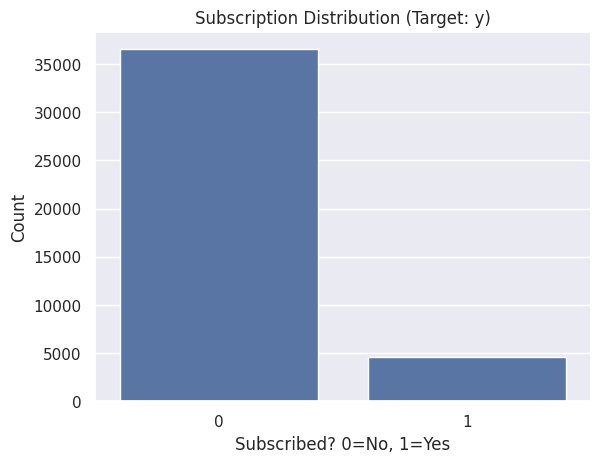

In [30]:
sns.countplot(x="y", data=df)
plt.title("Subscription Distribution (Target: y)")
plt.xlabel("Subscribed? 0=No, 1=Yes")
plt.ylabel("Count")
plt.show()


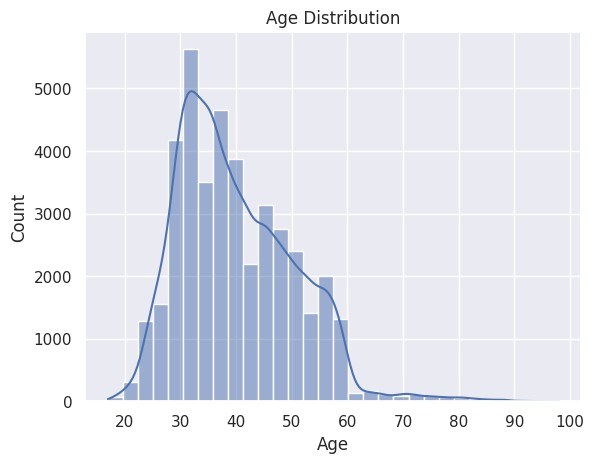

In [31]:
# Numeric example: Age distribution
sns.histplot(df["age"], bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


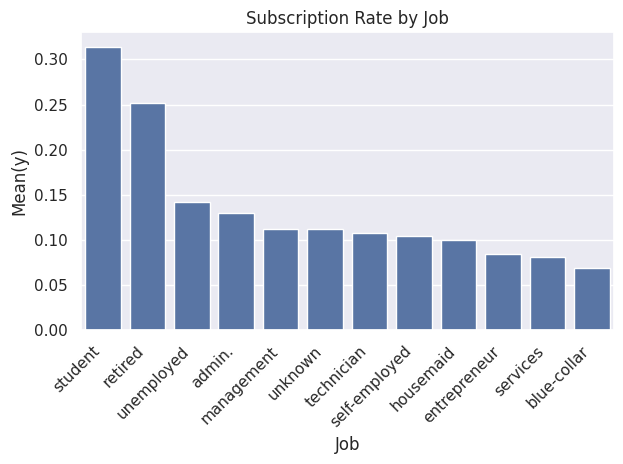

In [32]:
# Categorical vs target: subscription rate by job
rate_by_job = df.groupby("job")["y"].mean().sort_values(ascending=False).reset_index()
sns.barplot(x="job", y="y", data=rate_by_job)
plt.xticks(rotation=45, ha="right")
plt.title("Subscription Rate by Job")
plt.xlabel("Job")
plt.ylabel("Mean(y)")
plt.tight_layout()
plt.show()


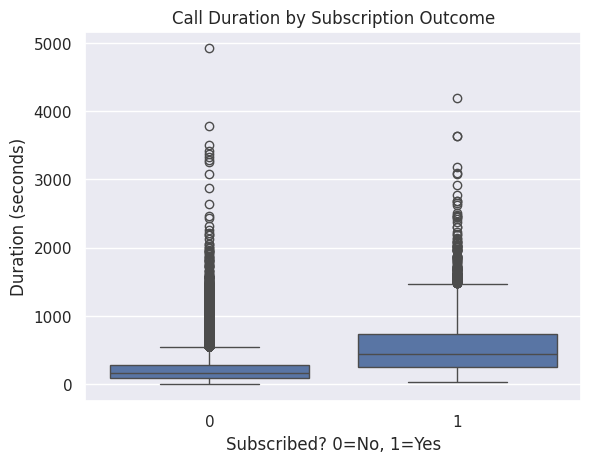

In [33]:
# Continuous vs target: duration by y (boxplot)
sns.boxplot(x="y", y="duration", data=df)
plt.title("Call Duration by Subscription Outcome")
plt.xlabel("Subscribed? 0=No, 1=Yes")
plt.ylabel("Duration (seconds)")
plt.show()


In [34]:
X = df_small.drop(columns=["y"])
y = df_small["y"].values

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))  # or sparse=True if older sklearn
    ]), cat_cols),
])


In [35]:
models = {
    "KNN (k=15)": KNeighborsClassifier(n_neighbors=15),
    "Logistic Regression": LogisticRegression(max_iter=300, solver="lbfgs"),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM (RBF, prob=False)": SVC(kernel="rbf", probability=False, random_state=42),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1": make_scorer(f1_score, zero_division=0),
    "roc_auc": "roc_auc",
}

rows = []
for name, model in models.items():
    pipe = Pipeline([("preprocess", preprocess), ("model", model)])
    cvres = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=1)
    rows.append({
        "Model": name,
        "Accuracy": cvres["test_accuracy"].mean(),
        "Precision": cvres["test_precision"].mean(),
        "Recall": cvres["test_recall"].mean(),
        "F1": cvres["test_f1"].mean(),
        "ROC_AUC": cvres["test_roc_auc"].mean(),
    })

results = pd.DataFrame(rows).sort_values("ROC_AUC", ascending=False).reset_index(drop=True)
results


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.915000,0.683776,0.457083,0.546891,0.936819
1,"SVM (RBF, prob=False)",0.912333,0.669960,0.433405,0.524664,0.920550
2,KNN (k=15),0.907500,0.654701,0.375700,0.476589,0.900309
3,Decision Tree,0.890000,0.511571,0.522163,0.516796,0.729433


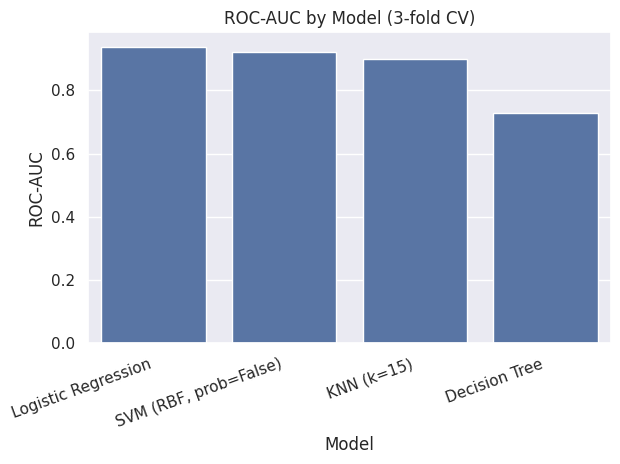

In [36]:
sns.barplot(x="Model", y="ROC_AUC", data=results)
plt.xticks(rotation=20, ha="right")
plt.title("ROC-AUC by Model (3-fold CV)")
plt.ylabel("ROC-AUC")
plt.tight_layout()
plt.show()


In [37]:
param_grid = {"model__C": [0.01, 0.1, 1, 10]}
pipe_lr = Pipeline([("preprocess", preprocess),
                    ("model", LogisticRegression(max_iter=500, solver="lbfgs"))])

grid = GridSearchCV(pipe_lr, param_grid=param_grid, cv=3, scoring="f1", n_jobs=1)
grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best CV F1:", grid.best_score_.round(4))


Best params: {'model__C': 10}
Best CV F1: 0.5504


In [38]:
logit = Pipeline([("preprocess", preprocess),
                  ("model", LogisticRegression(max_iter=500, solver="lbfgs"))])
logit.fit(X, y)

ohe = logit.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(cat_cols)
feat_names = np.r_[num_cols, cat_names]

coefs = pd.Series(logit.named_steps["model"].coef_[0], index=feat_names).sort_values(key=np.abs, ascending=False)
coefs.head(15)


,0
duration,1.354561
emp.var.rate,-1.060672
month_mar,0.917051
poutcome_failure,-0.822465
marital_unknown,0.759825
month_nov,-0.681835
contact_telephone,-0.672644
nr.employed,-0.663756
job_student,0.657762
month_may,-0.608001
